In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import math 

from quantizer import *
from utils import *

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()

In [2]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


def predict_output(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: d2l.reshape(d2l.tensor([outputs[-1]], device=device),
                                    (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])



def train_epoch(net, train_iter, loss, updater, device, stats, use_random_iter):
    """Train a net within one epoch"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)

        # quantize before forward pass 
        original_weights = simulate_quantization(net, stats)
        # forward pass on dequantized weights 
        y_hat, state = net(X, state)

        # restore original weights
        restore_original_weights(net, original_weights)

        # loss gets calculated on original weights 
        l = loss(y_hat, y.long()).mean()

        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)

        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


def train(net, train_iter, vocab, lr, num_epochs, device, stats,
              use_random_iter=False):
    """Train a model"""

    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    predict = lambda prefix: predict_output(prefix, 50, net, vocab, device)
    
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, stats,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])

    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


In [3]:
num_epochs, lr = 500, 1
num_inputs = vocab_size

### LSTM without quantization

perplexity 1.1, 31842.1 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


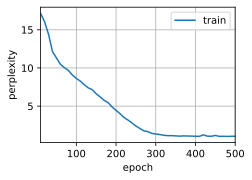

In [4]:
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### LSTM with Quantization

perplexity 1.1, 29485.3 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


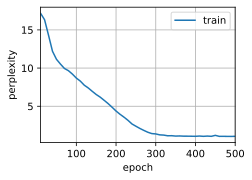

In [5]:

quantization_stats = {}
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model_qt = d2l.RNNModel(lstm_layer, len(vocab))
model_qt = model_qt.to(device)

train(model_qt, train_iter, vocab, lr, num_epochs, device, quantization_stats)



### Calculate the size of original and quantized models

In [6]:
size = calculate_size(model)
print(size)

Size (MB): 1.202533


In [7]:
size = calculate_size(model_qt, quantized=True)
print(size)

quantized
Size (MB): 0.302373


### Learned Scale and Zero Point of weights of each layer

In [8]:
quantization_stats 

{'LSTM.weight_ih_l0': (tensor(0.0209), 136),
 'LSTM.weight_hh_l0': (tensor(0.0085), 140),
 'LSTM.bias_ih_l0': (tensor(0.0044), 84),
 'LSTM.bias_hh_l0': (tensor(0.0047), 82),
 'Linear.weight': (tensor(0.0243), 124),
 'Linear.bias': (tensor(0.0070), 163)}

### Original Model Weights Distribution

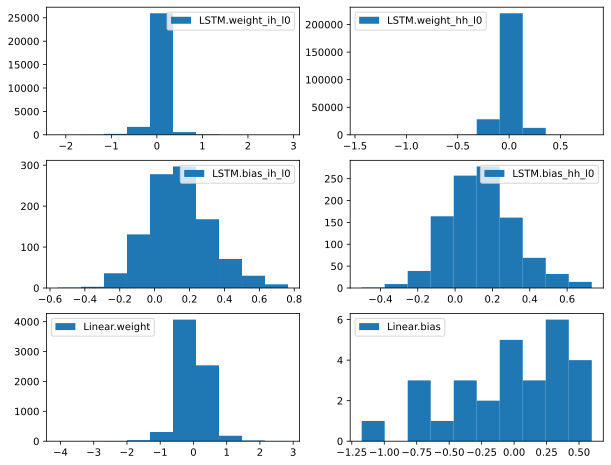

In [9]:
import copy
import matplotlib.pyplot as plt 

plots = visualize(3,2)


for layer, name, key in model_iterator(model):
    weights = layer._parameters[key].data
    subplot = next(plots)
    subplot.hist(weights.view(-1).cpu().numpy(), label=name)
    subplot.legend()
    
plt.show()

### Quantized Weights distribution

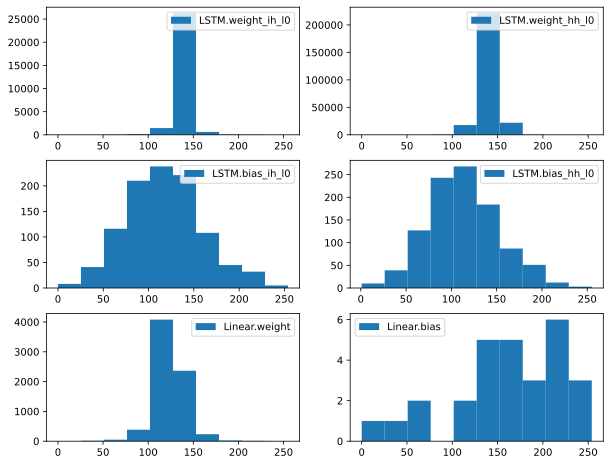

In [10]:
plots = visualize(3,2)

for layer, name, key in model_iterator(model_qt):
    weights = layer._parameters[key].data
    scale, zp = quantization_stats[name]
    weights  = quantize_tensor(weights, scale=scale, zero_point=zp)
    subplot = next(plots)
    subplot.hist(weights.tensor.view(-1).cpu().numpy(), label=name)
    subplot.legend()
    
plt.show()